## Preprocessing

### Imports

In [181]:
import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
from IPython.core.display_functions import display
from biogeme.expressions import Beta, Variable
from biogeme.models import loglogit, boxcox
from biogeme.segmentation import DiscreteSegmentationTuple, segmented_beta

### Load Data and Filter

Remove all those who shouldn't have access to cars but still chose it

In [182]:
data = pd.read_csv("lpmc01.dat", sep = '\t')

# Step 1: Identify whether each household has a driving license
data['household_has_license'] = data.groupby('household_id')['driving_license'].transform(lambda x: x.max())

# Step 2: Define a filter for the availability conditions not being met
car_availability_unmet = (data['car_ownership'] == 0) & (data['driving_license'] == 0) & (data['household_has_license'] == 0)

# Step 3: Identify rows where travel_mode is 4 (car) but the availability conditions are not met
car_without_availability = data[(data['travel_mode'] == 4) & car_availability_unmet]

# Step 4: Remove those rows from the original DataFrame
data_filtered = data[~data.index.isin(car_without_availability.index)]

database = db.Database('london', data_filtered)

### Explore Data 

Check statistics and graphs of Data

In [183]:
data_filtered.describe()

,trip_id,household_id,person_n,trip_n,travel_mode,purpose,fueltype,faretype,bus_scale,survey_year,...,dur_pt_rail,dur_pt_bus,dur_pt_int,pt_interchanges,dur_driving,cost_transit,cost_driving_fuel,cost_driving_ccharge,driving_traffic_percent,household_has_license
count,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,...,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000
mean,40237.209472,8643.030763,0.773932,1.538353,3.047359,2.888687,2.780814,2.205829,0.662619,1.974094,...,0.091402,0.172350,0.044814,0.371180,0.284220,1.599806,0.837735,1.145416,0.336556,0.689334
std,23379.474440,5064.169881,1.027603,1.768024,1.081396,1.188233,2.218510,1.720187,0.466398,0.816912,...,0.175669,0.190150,0.078959,0.623633,0.253322,1.525741,0.821638,3.273692,0.200867,0.462813
min,12.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.009722,0.000000,0.030000,0.000000,0.000000,0.000000
25%,19903.000000,4214.000000,0.000000,0.000000,3.000000,2.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.035833,0.000000,0.000000,0.107500,0.000000,0.280000,0.000000,0.172973,0.000000
50%,40280.000000,8615.000000,0.000000,1.000000,3.000000,3.000000,2.000000,1.000000,1.000000,2.000000,...,0.000000,0.111111,0.000000,0.000000,0.189167,1.500000,0.540000,0.000000,0.304348,1.000000
75%,60195.000000,12907.000000,1.000000,2.000000,4.000000,3.000000,6.000000,4.000000,1.000000,3.000000,...,0.100000,0.250000,0.091667,1.000000,0.378056,2.400000,1.120000,0.000000,0.488011,1.000000
max,81084.000000,17615.000000,7.000000,14.000000,4.000000,5.000000,6.000000,5.000000,1.000000,3.000000,...,1.183333,1.871944,0.750000,4.000000,1.730556,10.600000,8.630000,10.500000,0.957627,1.000000


In [184]:
pt_data = data_filtered[data_filtered['travel_mode'] == 3]

pt_data[['cost_transit', 'faretype', 'bus_scale']].describe()

,cost_transit,faretype,bus_scale
count,1766.000000,1766.000000,1766.000000
mean,1.947571,2.270102,0.636183
std,1.853382,1.710186,0.471270
min,0.000000,1.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,1.500000,1.000000,1.000000
75%,3.000000,4.000000,1.000000
max,10.100000,5.000000,1.000000


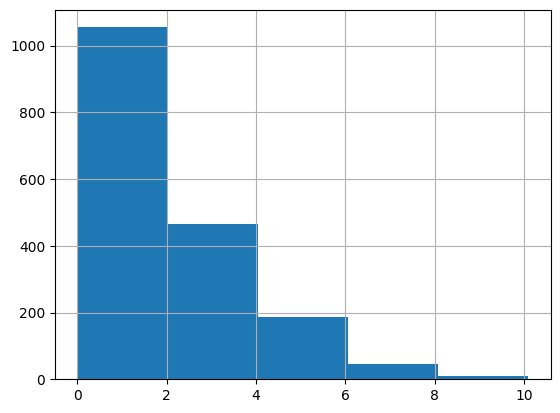

In [185]:
hist = pt_data['cost_transit'].hist(bins=5)

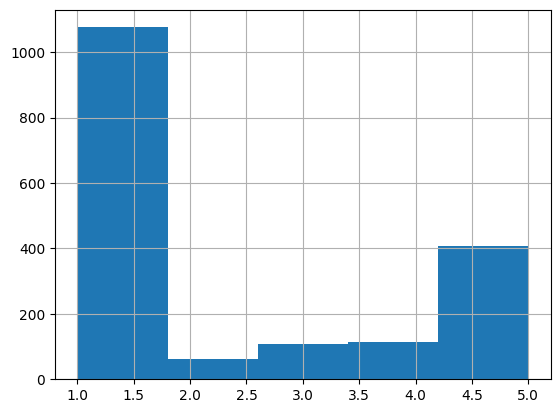

In [186]:
hist = pt_data['faretype'].hist(bins=5)


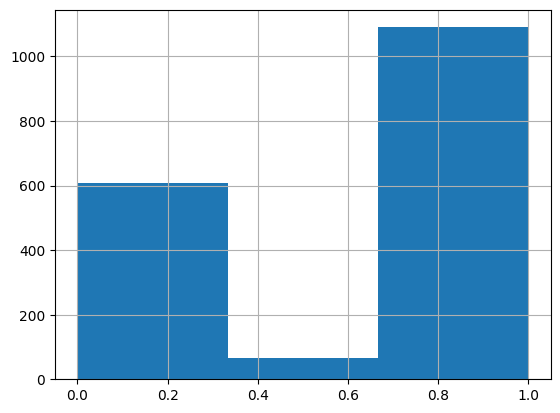

In [187]:
hist = pt_data['bus_scale'].hist(bins=3)

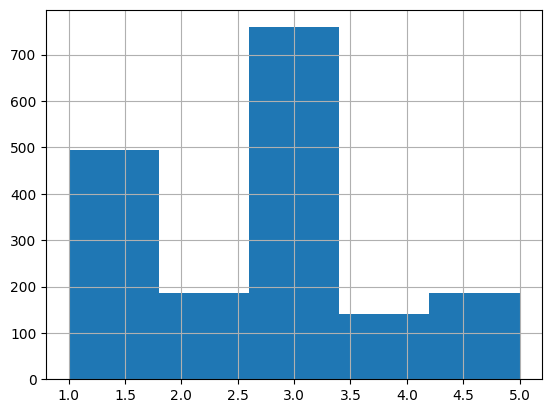

In [188]:
hist = pt_data['purpose'].hist(bins=5)

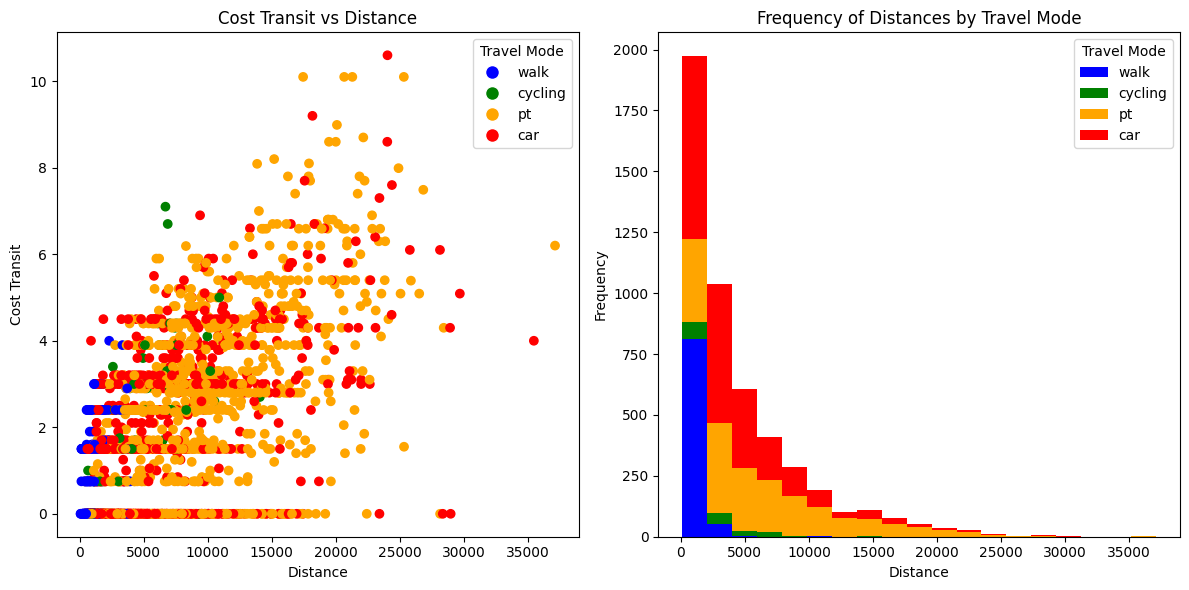

In [189]:
distance = data_filtered['distance']
cost_transit = data_filtered['cost_transit']
choice = data_filtered['travel_mode']
choices = ['walk', 'cycling', 'pt', 'car']

import matplotlib.pyplot as plt
import numpy as np

# Define colors for each choice (1, 2, 3, 4)
color_map = {1: 'blue', 2: 'green', 3: 'orange', 4: 'red'}
labels = {1: 'walk', 2: 'cycling', 3: 'pt', 4: 'car'}

# Separate distances by travel mode
distance_by_mode = {mode: distance[choice == mode] for mode in color_map}

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot with color based on choice
colors = [color_map[c] for c in choice]
axes[0].scatter(distance, cost_transit, c=colors)
axes[0].set_title("Cost Transit vs Distance")
axes[0].set_xlabel("Distance")
axes[0].set_ylabel("Cost Transit")

# Create custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[i], markersize=10, label=labels[i]) for i in color_map]
axes[0].legend(handles=legend_elements, title="Travel Mode")

# Stacked histogram for travel modes
bins = np.linspace(min(distance), max(distance), 20)
hist_data = [distance_by_mode[mode] for mode in color_map]
axes[1].hist(hist_data, bins=bins, stacked=True, color=[color_map[i] for i in color_map], label=[labels[i] for i in color_map])

axes[1].set_xlabel("Distance")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Frequency of Distances by Travel Mode")
axes[1].legend(title="Travel Mode")

plt.tight_layout()
plt.show()


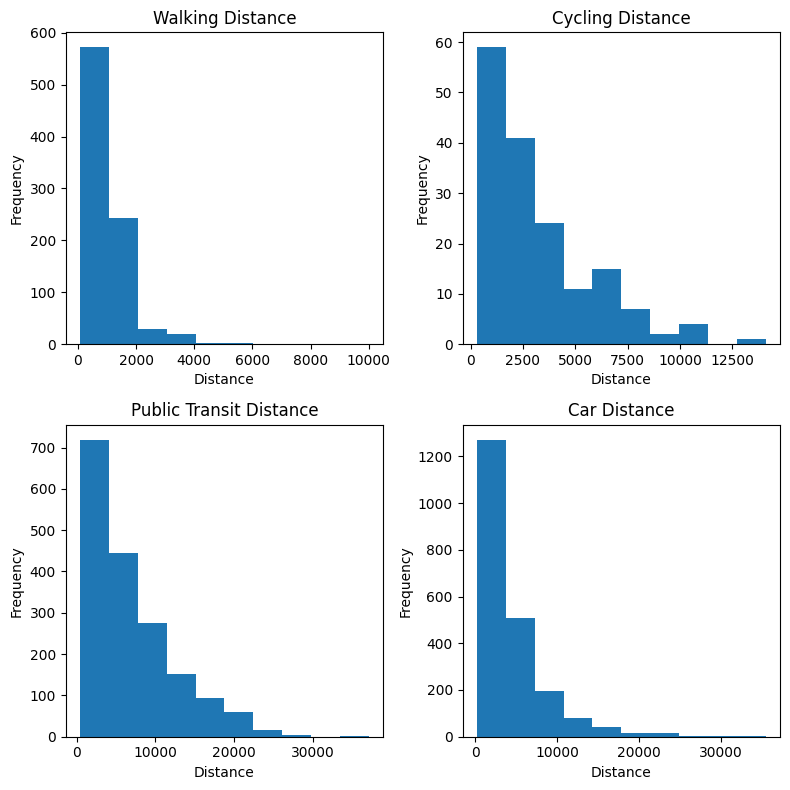

In [190]:
walk_distance = distance[choice == 1]
cycling_distance = distance[choice == 2]
pt_distance = distance[choice == 3]
car_distance = distance[choice == 4]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

# Plot histograms for each travel mode with titles
axes[0].hist(walk_distance)
axes[0].set_title("Walking Distance")
axes[0].set_xlabel("Distance")
axes[0].set_ylabel("Frequency")

axes[1].hist(cycling_distance)
axes[1].set_title("Cycling Distance")
axes[1].set_xlabel("Distance")
axes[1].set_ylabel("Frequency")

axes[2].hist(pt_distance)
axes[2].set_title("Public Transit Distance")
axes[2].set_xlabel("Distance")
axes[2].set_ylabel("Frequency")

axes[3].hist(car_distance)
axes[3].set_title("Car Distance")
axes[3].set_xlabel("Distance")
axes[3].set_ylabel("Frequency")

plt.tight_layout()
plt.show()




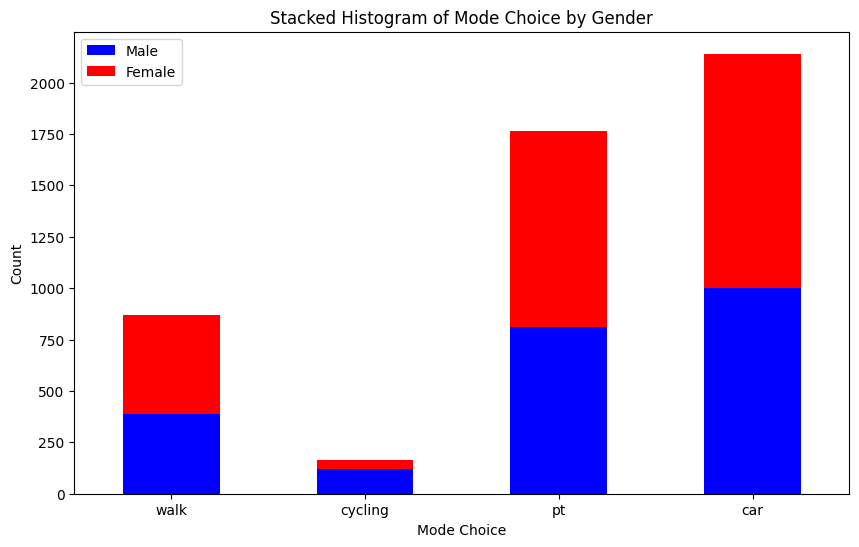

In [191]:
# Count occurrences of each choice by gender
counts = data_filtered.groupby(['travel_mode', 'female']).size().unstack(fill_value=0)

# Plot the stacked bar chart
ax = counts.plot(kind='bar', stacked=True, color=['blue', 'red'], figsize=(10, 6))
plt.xlabel('Mode Choice')
plt.ylabel('Count')
plt.title('Stacked Histogram of Mode Choice by Gender')
plt.legend(['Male', 'Female'])

mode_choices = ['walk', 'cycling', 'pt', 'car']
ax.set_xticks(range(len(mode_choices)))
ax.set_xticklabels(mode_choices, rotation=0)  # Set custom labels

plt.show()

## Variable Definition

In [192]:
trip_id = Variable('trip_id')
household_id = Variable('household_id')
person_n = Variable('person_n')
trip_n = Variable('trip_n')
travel_mode = Variable('travel_mode')
purpose = Variable('purpose')
fueltype = Variable('fueltype')
faretype = Variable('faretype')
bus_scale = Variable('bus_scale')
survey_year = Variable('survey_year')
travel_year = Variable('travel_year')
travel_month = Variable('travel_month')
travel_date = Variable('travel_date')
day_of_week = Variable('day_of_week')
start_time = Variable('start_time')
age = Variable('age')
female = Variable('female')
driving_license = Variable('driving_license')
car_ownership = Variable('car_ownership')
distance = Variable('distance')
dur_walking = Variable('dur_walking')
dur_cycling = Variable('dur_cycling')
dur_pt_access = Variable('dur_pt_access') # Predicted total access and egress time for public transport route in hours
dur_pt_rail = Variable('dur_pt_rail')
dur_pt_bus = Variable('dur_pt_bus')
dur_pt_int = Variable('dur_pt_int') # Time taken (hrs) at each interchange point
pt_interchanges = Variable('pt_interchanges')   # Number of interchange points in public transport route
dur_driving = Variable('dur_driving')
cost_transit = Variable('cost_transit')
cost_driving_fuel = Variable('cost_driving_fuel')   # Estimated fuel cost of driving route in GBP
cost_driving_ccharge = Variable('cost_driving_ccharge')  # Estimated congestion charge cost of driving route in GBP
driving_traffic_percent = Variable('driving_traffic_percent')

household_has_license = Variable('household_has_license')


In [193]:
# Define driving cost
cost_driving = cost_driving_ccharge + cost_driving_fuel

# Define time taken by each mode of transport
time_pt = dur_pt_access + dur_pt_rail + dur_pt_bus + dur_pt_int 

time_cycling = dur_cycling
time_walking = dur_walking
time_driving = dur_driving

## Model 0

Only generic ASCs and parameters

In [194]:
# Define ASCs 
asc_car = Beta(name='asc_car', value=0, lowerbound=None, upperbound=None, status=0)
asc_walk = Beta(name='asc_walk', value=0, lowerbound=None, upperbound=None, status=0)
asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define generic parameters

beta_cost = Beta(name='beta_cost', value=0, lowerbound=None, upperbound=None, status=0)
beta_time = Beta(name='beta_time', value=0, lowerbound=None, upperbound=None, status=0)


In [195]:
# Define utility functions

v_car = asc_car + beta_cost * cost_driving + beta_time * time_driving

v_walk = asc_walk + beta_time * time_walking

v_pt = asc_pt + beta_cost * cost_transit + beta_time * time_pt

v_cycling = beta_time * time_cycling

In [196]:
# Availability

V = {1: v_walk, 2: v_cycling, 3: v_pt, 4: v_car}

CAR_AV = (car_ownership != 0) | (driving_license != 0) | (household_has_license != 0)
WALK_AV = (car_ownership >= 0)
PT_AV = (car_ownership >= 0)
CYCLING_AV = (car_ownership >= 0)

av = {1: WALK_AV, 2: CYCLING_AV , 3: PT_AV, 4: CAR_AV}

In [197]:
logprob_m0 = loglogit(V, av, travel_mode)

model_0 = bio.BIOGEME(database, logprob_m0)
model_0.modelName = 'model_0'

null_log_likelihood_m0 = model_0.calculate_null_loglikelihood(av)

results_m0 = model_0.estimate()

print(results_m0.print_general_statistics())

Number of estimated parameters:	5
Sample size:	4941
Excluded observations:	0
Null log likelihood:	-6610.329
Init log likelihood:	-4007.051
Final log likelihood:	-4007.051
Likelihood ratio test for the null model:	5206.557
Rho-square for the null model:	0.394
Rho-square-bar for the null model:	0.393
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00125
Akaike Information Criterion:	8024.101
Bayesian Information Criterion:	8056.628
Final gradient norm:	2.4196E-03
Nbr of threads:	16



In [198]:
pd_results_m0 = results_m0.get_estimated_parameters()
display(pd_results_m0)


,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_car,2.904088,0.091323,31.800297,0.0
asc_pt,3.355414,0.094523,35.498546,0.0
asc_walk,3.945274,0.112873,34.953192,0.0
beta_cost,-0.206632,0.015116,-13.669511,0.0
beta_time,-5.974888,0.227355,-26.280001,0.0


## Model 1: Time alternative specific

In [199]:
# Define ASCs 
asc_car = Beta(name='asc_car', value=0, lowerbound=None, upperbound=None, status=0)
asc_walk = Beta(name='asc_walk', value=0, lowerbound=None, upperbound=None, status=0)
asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define generic parameters

beta_time = Beta(name='beta_time', value=0, lowerbound=None, upperbound=None, status=0)

# Define alternative specific parameters

beta_cost_car = Beta(name='beta_cost_car', value=0, lowerbound=None, upperbound=None, status=0)
beta_cost_pt = Beta(name='beta_cost_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define utility functions

v_car = asc_car + beta_cost_car * cost_driving + beta_time * time_driving

v_walk = asc_walk + beta_time * time_walking

v_pt = asc_pt + beta_cost_pt * cost_transit + beta_time * time_pt

v_cycling = beta_time * time_cycling

V = {1: v_walk, 2: v_cycling, 3: v_pt, 4: v_car}

CAR_AV = (car_ownership != 0) | (driving_license != 0) | (household_has_license != 0)
WALK_AV = (car_ownership >= 0)
PT_AV = (car_ownership >= 0)
CYCLING_AV = (car_ownership >= 0)

av = {1: WALK_AV, 2: CYCLING_AV , 3: PT_AV, 4: CAR_AV}

logprob_m1 = loglogit(V, av, travel_mode)

model_1 = bio.BIOGEME(database, logprob_m1)
model_1.modelName = 'model_1'

null_log_likelihood_m1 = model_1.calculate_null_loglikelihood(av)

results_m1 = model_1.estimate()
print(results_m1.print_general_statistics())


Number of estimated parameters:	6
Sample size:	4941
Excluded observations:	0
Null log likelihood:	-6610.329
Init log likelihood:	-3943.179
Final log likelihood:	-3943.179
Likelihood ratio test for the null model:	5334.3
Rho-square for the null model:	0.403
Rho-square-bar for the null model:	0.403
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00152
Akaike Information Criterion:	7898.358
Bayesian Information Criterion:	7937.39
Final gradient norm:	3.0455E-03
Nbr of threads:	16



In [200]:
pd_results_m1 = results_m1.get_estimated_parameters()
display(pd_results_m1)


,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_car,2.943863,0.089855,32.762269,0.000000
asc_pt,2.938992,0.101225,29.034215,0.000000
asc_walk,3.856686,0.112950,34.145113,0.000000
beta_cost_car,-0.265049,0.026493,-10.004318,0.000000
beta_cost_pt,0.050389,0.030430,1.655867,0.097749
beta_time,-5.934685,0.231000,-25.691233,0.000000


### Comparison between Model 0 and Model 1

In [201]:
loglikehood_m0 = results_m0.data.logLike
num_params_m0 = results_m0.data.nparam

loglikehood_m1 = results_m1.data.logLike
num_params_m1 = results_m1.data.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_m1 - loglikehood_m0)

# Degrees of freedom
df = num_params_m1 - num_params_m0

from scipy.stats import chi2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model 1 is significantly better than Model 0.")
else:
    print("No significant improvement in Model 1 over Model 0.")



Likelihood Ratio: 127.74355927711531
Degrees of Freedom: 1
Critical Chi-Square Value (0.05 significance): 3.841458820694124
Model 1 is significantly better than Model 0.


We find that Model 1 is better than Model 0 based on the likelihood test

## Model 2: Socio-economic interactions (Sex)

In [202]:
# Time segmentation
sex_segmentation = DiscreteSegmentationTuple(
    variable=female, mapping={0: 'other', 1: 'female'}
)

### Model 2A: Sex interaction with Time

In [203]:
# Define ASCs 
asc_car = Beta(name='asc_car', value=0, lowerbound=None, upperbound=None, status=0)
asc_walk = Beta(name='asc_walk', value=0, lowerbound=None, upperbound=None, status=0)
asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define generic parameters

beta_time = Beta(name='beta_time', value=0, lowerbound=None, upperbound=None, status=0)

segmented_B_time = segmented_beta(beta_time, [sex_segmentation])

# Define alternative specific parameters

beta_cost_car = Beta(name='beta_cost_car', value=0, lowerbound=None, upperbound=None, status=0)
beta_cost_pt = Beta(name='beta_cost_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define utility functions

v_car = asc_car + beta_cost_car * cost_driving + segmented_B_time * time_driving

v_walk = asc_walk + segmented_B_time * time_walking

v_pt = asc_pt + beta_cost_pt * cost_transit + segmented_B_time * time_pt

v_cycling = segmented_B_time * time_cycling

V = {1: v_walk, 2: v_cycling, 3: v_pt, 4: v_car}

CAR_AV = (car_ownership != 0) | (driving_license != 0) | (household_has_license != 0)
WALK_AV = (car_ownership >= 0)
PT_AV = (car_ownership >= 0)
CYCLING_AV = (car_ownership >= 0)

av = {1: WALK_AV, 2: CYCLING_AV , 3: PT_AV, 4: CAR_AV}

In [204]:
logprob_m2a = loglogit(V, av, travel_mode)

model_2a = bio.BIOGEME(database, logprob_m2a)
model_2a.modelName = 'model_2a'

null_log_likelihood_m2a = model_2a.calculate_null_loglikelihood(av)

results_m2a = model_2a.estimate()
print(results_m2a.print_general_statistics())


Number of estimated parameters:	7
Sample size:	4941
Excluded observations:	0
Null log likelihood:	-6610.329
Init log likelihood:	-3943.101
Final log likelihood:	-3943.101
Likelihood ratio test for the null model:	5334.455
Rho-square for the null model:	0.403
Rho-square-bar for the null model:	0.402
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00178
Akaike Information Criterion:	7900.203
Bayesian Information Criterion:	7945.74
Final gradient norm:	3.8666E-03
Nbr of threads:	16



In [205]:
pd_results_m2a = results_m2a.get_estimated_parameters()
display(pd_results_m2a)

,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_car,2.943807,0.089851,32.763102,0.000000
asc_pt,2.938448,0.101320,29.001769,0.000000
asc_walk,3.856007,0.113037,34.112845,0.000000
beta_cost_car,-0.265288,0.026525,-10.001362,0.000000
beta_cost_pt,0.050593,0.030476,1.660084,0.096897
beta_time,-5.987109,0.277836,-21.549062,0.000000
beta_time_female,0.097284,0.262770,0.370225,0.711215


### Model 2B: Sex interaction with all ASCs

In [206]:
# Define ASCs 
asc_car = Beta(name='asc_car', value=0, lowerbound=None, upperbound=None, status=0)
asc_walk = Beta(name='asc_walk', value=0, lowerbound=None, upperbound=None, status=0)
asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define generic parameters

beta_time = Beta(name='beta_time', value=0, lowerbound=None, upperbound=None, status=0)

# Define alternative specific parameters

beta_cost_car = Beta(name='beta_cost_car', value=0, lowerbound=None, upperbound=None, status=0)
beta_cost_pt = Beta(name='beta_cost_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Segmented Walk ASC

segmented_ASC_walk = segmented_beta(asc_walk, [sex_segmentation])
segmented_ASC_car = segmented_beta(asc_car, [sex_segmentation])
segmented_ASC_pt = segmented_beta(asc_pt, [sex_segmentation])
ASC_cycling_female = Beta(name='asc_cycling_female', value=0, lowerbound=None, upperbound=None, status=0)

# Define utility functions

# v_car = segmented_ASC_car + beta_cost_car * cost_driving + beta_time * time_driving
# v_walk = segmented_ASC_walk + beta_time * time_walking
# v_pt = segmented_ASC_pt + beta_cost_pt * cost_transit + beta_time * time_pt


v_car = asc_car + beta_cost_car * cost_driving + beta_time * time_driving
v_walk = asc_walk + beta_time * time_walking
v_pt = asc_pt + beta_cost_pt * cost_transit + beta_time * time_pt

v_cycling = ASC_cycling_female * (female == 1) + beta_time * time_cycling

V = {1: v_walk, 2: v_cycling, 3: v_pt, 4: v_car}

CAR_AV = (car_ownership != 0) | (driving_license != 0) | (household_has_license != 0)
WALK_AV = (car_ownership >= 0)
PT_AV = (car_ownership >= 0)
CYCLING_AV = (car_ownership >= 0)

av = {1: WALK_AV, 2: CYCLING_AV , 3: PT_AV, 4: CAR_AV}

In [207]:
logprob_m2b = loglogit(V, av, travel_mode)

model_2b = bio.BIOGEME(database, logprob_m2b)
model_2b.modelName = 'model_2b'

null_log_likelihood_m2b = model_2b.calculate_null_loglikelihood(av)

results_m2b = model_2b.estimate()
print(results_m2b.print_general_statistics())


Number of estimated parameters:	7
Sample size:	4941
Excluded observations:	0
Null log likelihood:	-6610.329
Init log likelihood:	-3912.876
Final log likelihood:	-3912.876
Likelihood ratio test for the null model:	5394.906
Rho-square for the null model:	0.408
Rho-square-bar for the null model:	0.407
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00179
Akaike Information Criterion:	7839.752
Bayesian Information Criterion:	7885.289
Final gradient norm:	3.8928E-04
Nbr of threads:	16



In [208]:
pd_results_m2b = results_m2b.get_estimated_parameters()
display(pd_results_m2b)

,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_car,2.406767,0.104246,23.087353,0.000000e+00
asc_cycling_female,-1.334317,0.188681,-7.071819,1.529221e-12
asc_pt,2.404014,0.113327,21.213045,0.000000e+00
asc_walk,3.328553,0.122240,27.229672,0.000000e+00
beta_cost_car,-0.263671,0.026387,-9.992639,0.000000e+00
beta_cost_pt,0.053246,0.030315,1.756444,7.901269e-02
beta_time,-5.969304,0.232432,-25.681972,0.000000e+00


### Compare Model 2b with Model 1

In [209]:
loglikehood_m2b = results_m2b.data.logLike
num_params_m2b = results_m2b.data.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_m2b - loglikehood_m1)

# Degrees of freedom
df = num_params_m2b - num_params_m1

from scipy.stats import chi2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model 2b is significantly better than Model 1.")
else:
    print("No significant improvement in Model 2b over Model 1.")



Likelihood Ratio: 60.605716130319706
Degrees of Freedom: 1
Critical Chi-Square Value (0.05 significance): 3.841458820694124
Model 2b is significantly better than Model 1.


### Compare Segmenting all ASCs vs just Cycling

In [210]:
# Define ASCs 
asc_car = Beta(name='asc_car', value=0, lowerbound=None, upperbound=None, status=0)
asc_walk = Beta(name='asc_walk', value=0, lowerbound=None, upperbound=None, status=0)
asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define generic parameters

beta_time = Beta(name='beta_time', value=0, lowerbound=None, upperbound=None, status=0)

# Define alternative specific parameters

beta_cost_car = Beta(name='beta_cost_car', value=0, lowerbound=None, upperbound=None, status=0)
beta_cost_pt = Beta(name='beta_cost_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Segmented Walk ASC

segmented_ASC_walk = segmented_beta(asc_walk, [sex_segmentation])
segmented_ASC_car = segmented_beta(asc_car, [sex_segmentation])
segmented_ASC_pt = segmented_beta(asc_pt, [sex_segmentation])
ASC_cycling_female = Beta(name='asc_cycling_female', value=0, lowerbound=None, upperbound=None, status=0)

# Define utility functions

v_car = segmented_ASC_car + beta_cost_car * cost_driving + beta_time * time_driving
v_walk = segmented_ASC_walk + beta_time * time_walking
v_pt = segmented_ASC_pt + beta_cost_pt * cost_transit + beta_time * time_pt

v_cycling = ASC_cycling_female * (female == 1) + beta_time * time_cycling

V = {1: v_walk, 2: v_cycling, 3: v_pt, 4: v_car}

CAR_AV = (car_ownership != 0) | (driving_license != 0) | (household_has_license != 0)
WALK_AV = (car_ownership >= 0)
PT_AV = (car_ownership >= 0)
CYCLING_AV = (car_ownership >= 0)

av = {1: WALK_AV, 2: CYCLING_AV , 3: PT_AV, 4: CAR_AV}

In [211]:
logprob_m2b_all = loglogit(V, av, travel_mode)

model_2b_all = bio.BIOGEME(database, logprob_m2b_all)
model_2b_all.modelName = 'model_2b_all'

null_log_likelihood_m2b_all = model_2b_all.calculate_null_loglikelihood(av)

results_m2b_all = model_2b_all.estimate()
print(results_m2b_all.print_general_statistics())


Number of estimated parameters:	10
Sample size:	4941
Excluded observations:	0
Null log likelihood:	-6610.329
Init log likelihood:	-3910.55
Final log likelihood:	-3910.55
Likelihood ratio test for the null model:	5399.559
Rho-square for the null model:	0.408
Rho-square-bar for the null model:	0.407
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00256
Akaike Information Criterion:	7841.099
Bayesian Information Criterion:	7906.153
Final gradient norm:	4.6180E-03
Nbr of threads:	16



In [212]:
loglikehood_m2b_all = results_m2b_all.data.logLike
num_params_m2b_all = results_m2b_all.data.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_m2b_all - loglikehood_m2b)

# Degrees of freedom
df = num_params_m2b_all - num_params_m2b

from scipy.stats import chi2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model 2b_all is significantly better than Model 2b.")
else:
    print("No significant improvement in Model 2b_all over Model 2b.")



Likelihood Ratio: 4.652472993563606
Degrees of Freedom: 3
Critical Chi-Square Value (0.05 significance): 7.814727903251179
No significant improvement in Model 2b_all over Model 2b.


## Model 3: Non-linear specification

In [213]:
# Define ASCs 
asc_car = Beta(name='asc_car', value=0, lowerbound=None, upperbound=None, status=0)
asc_walk = Beta(name='asc_walk', value=0, lowerbound=None, upperbound=None, status=0)
asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define generic parameters

beta_time = Beta(name='beta_time', value=0, lowerbound=None, upperbound=None, status=0)
LAMBDA = Beta('LAMBDA', 0, None, None, 0)

# Define alternative specific parameters

beta_cost_car = Beta(name='beta_cost_car', value=0, lowerbound=None, upperbound=None, status=0)
beta_cost_pt = Beta(name='beta_cost_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Segmented Walk ASC

ASC_cycling_female = Beta(name='asc_cycling_female', value=0, lowerbound=None, upperbound=None, status=0)

# Define utility functions

v_car = asc_car + beta_cost_car * cost_driving + beta_time * boxcox(time_driving,LAMBDA)
v_walk = asc_walk + beta_time * boxcox(time_walking,LAMBDA)
v_pt = asc_pt + beta_cost_pt * cost_transit + beta_time * boxcox(time_pt,LAMBDA)

v_cycling = ASC_cycling_female * (female == 1) + beta_time * boxcox(time_cycling,LAMBDA)

V = {1: v_walk, 2: v_cycling, 3: v_pt, 4: v_car}

CAR_AV = (car_ownership != 0) | (driving_license != 0) | (household_has_license != 0)
WALK_AV = (car_ownership >= 0)
PT_AV = (car_ownership >= 0)
CYCLING_AV = (car_ownership >= 0)

av = {1: WALK_AV, 2: CYCLING_AV , 3: PT_AV, 4: CAR_AV}

It is advised to set the bounds on parameter LAMBDA. A value of -10 and 10 should be appropriate: Beta("LAMBDA", 0, -10, 10, 0)
It is advised to set the bounds on parameter LAMBDA. A value of -10 and 10 should be appropriate: Beta("LAMBDA", 0, -10, 10, 0)
It is advised to set the bounds on parameter LAMBDA. A value of -10 and 10 should be appropriate: Beta("LAMBDA", 0, -10, 10, 0)
It is advised to set the bounds on parameter LAMBDA. A value of -10 and 10 should be appropriate: Beta("LAMBDA", 0, -10, 10, 0)


In [214]:
logprob_m3 = loglogit(V, av, travel_mode)

model_3 = bio.BIOGEME(database, logprob_m3)
model_3.modelName = 'model_3'

null_log_likelihood_m3 = model_3.calculate_null_loglikelihood(av)

results_m3 = model_3.estimate()
print(results_m3.print_general_statistics())


Number of estimated parameters:	8
Sample size:	4941
Excluded observations:	0
Null log likelihood:	-6610.329
Init log likelihood:	-3822.292
Final log likelihood:	-3822.292
Likelihood ratio test for the null model:	5576.074
Rho-square for the null model:	0.422
Rho-square-bar for the null model:	0.421
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00209
Akaike Information Criterion:	7660.584
Bayesian Information Criterion:	7712.626
Final gradient norm:	1.0293E-01
Nbr of threads:	16



In [215]:
pd_results_m3 = results_m3.get_estimated_parameters()
display(pd_results_m3)

,Value,Rob. Std err,Rob. t-test,Rob. p-value
LAMBDA,0.480279,0.023742,20.228786,0.000000e+00
asc_car,2.137815,0.104259,20.504826,0.000000e+00
asc_cycling_female,-1.358128,0.187009,-7.262372,3.803624e-13
asc_pt,3.029652,0.123595,24.512744,0.000000e+00
asc_walk,4.407632,0.147120,29.959525,0.000000e+00
beta_cost_car,-0.196301,0.021652,-9.066256,0.000000e+00
beta_cost_pt,-0.038949,0.029644,-1.313875,1.888884e-01
beta_time,-5.384872,0.165841,-32.470084,0.000000e+00


### Compare Model 3 with Model 2   

#### Model C

In [ ]:
# Define ASCs 
asc_car = Beta(name='asc_car', value=0, lowerbound=None, upperbound=None, status=0)
asc_walk = Beta(name='asc_walk', value=0, lowerbound=None, upperbound=None, status=0)
asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define generic parameters

beta_time = Beta(name='beta_time', value=0, lowerbound=None, upperbound=None, status=0)
beta_time_lambda = Beta(name='beta_time_lambda', value=0, lowerbound=None, upperbound=None, status=0)
LAMBDA = Beta('LAMBDA', 0, None, None, 0)

# Define alternative specific parameters

beta_cost_car = Beta(name='beta_cost_car', value=0, lowerbound=None, upperbound=None, status=0)
beta_cost_pt = Beta(name='beta_cost_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Segmented Walk ASC

ASC_cycling_female = Beta(name='asc_cycling_female', value=0, lowerbound=None, upperbound=None, status=0)

# Define utility functions

v_car = asc_car + beta_cost_car * cost_driving + beta_time_lambda * boxcox(time_driving,LAMBDA) + beta_time * time_driving
v_walk = asc_walk + beta_time_lambda * boxcox(time_walking,LAMBDA) + beta_time * time_walking
v_pt = asc_pt + beta_cost_pt * cost_transit + beta_time_lambda * boxcox(time_pt,LAMBDA) + beta_time * time_pt

v_cycling = ASC_cycling_female * (female == 1) + beta_time_lambda * boxcox(time_cycling,LAMBDA) + beta_time * time_cycling

V = {1: v_walk, 2: v_cycling, 3: v_pt, 4: v_car}

CAR_AV = (car_ownership != 0) | (driving_license != 0) | (household_has_license != 0)
WALK_AV = (car_ownership >= 0)
PT_AV = (car_ownership >= 0)
CYCLING_AV = (car_ownership >= 0)

av = {1: WALK_AV, 2: CYCLING_AV , 3: PT_AV, 4: CAR_AV}

It is advised to set the bounds on parameter LAMBDA. A value of -10 and 10 should be appropriate: Beta("LAMBDA", 0, -10, 10, 0)
It is advised to set the bounds on parameter LAMBDA. A value of -10 and 10 should be appropriate: Beta("LAMBDA", 0, -10, 10, 0)
It is advised to set the bounds on parameter LAMBDA. A value of -10 and 10 should be appropriate: Beta("LAMBDA", 0, -10, 10, 0)
It is advised to set the bounds on parameter LAMBDA. A value of -10 and 10 should be appropriate: Beta("LAMBDA", 0, -10, 10, 0)


In [217]:
logprob_mC = loglogit(V, av, travel_mode)

model_C = bio.BIOGEME(database, logprob_mC)
model_C.modelName = 'model_C'

null_log_likelihood_mC = model_C.calculate_null_loglikelihood(av)

results_mC = model_C.estimate()
print(results_mC.print_general_statistics())


Number of estimated parameters:	8
Sample size:	4941
Excluded observations:	0
Null log likelihood:	-6610.329
Init log likelihood:	-3830.985
Final log likelihood:	-3830.985
Likelihood ratio test for the null model:	5558.687
Rho-square for the null model:	0.42
Rho-square-bar for the null model:	0.419
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00209
Akaike Information Criterion:	7677.971
Bayesian Information Criterion:	7730.014
Final gradient norm:	1.5231E-01
Nbr of threads:	16



#### Test C vs 2b

In [218]:
loglikehood_mC = results_mC.data.logLike
num_params_mC = results_mC.data.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_mC - loglikehood_m2b)

# Degrees of freedom
df = num_params_mC - num_params_m2b

from scipy.stats import chi2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model C is significantly better than Model 2b.")
else:
    print("No significant improvement in Model C over Model 2b.")



Likelihood Ratio: 163.78087626283286
Degrees of Freedom: 1
Critical Chi-Square Value (0.05 significance): 3.841458820694124
Model C is significantly better than Model 2b.


#### Test C vs 3

In [219]:
loglikehood_m3 = results_m3.data.logLike
num_params_m3 = results_m3.data.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_mC - loglikehood_m3)

# Degrees of freedom
df = num_params_mC - num_params_m2b

from scipy.stats import chi2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model C is significantly better than Model 3.")
else:
    print("No significant improvement in Model C over Model 3.")



Likelihood Ratio: -17.387242370594322
Degrees of Freedom: 1
Critical Chi-Square Value (0.05 significance): 3.841458820694124
No significant improvement in Model C over Model 3.
